In [66]:
'''
Kütüphaneleri İmport Edelim
'''

import numpy as np # Lineer cebir işlemleri için
import pandas as pd # Veri işlemek için
import seaborn as sns # Veri görselleşirmek için
import matplotlib.pyplot as plt # Veri görselleşirmek için
from scipy import stats # İleri seviye istatistiksel hesaplamalar için
from scipy.stats import norm, skew
from sklearn.preprocessing import RobustScaler, StandardScaler # Veriyi scale(ölçeklendirmek) için
from sklearn.model_selection import train_test_split, GridSearchCV # Modelimize hazır hale gerimek için
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
# Modelimizin doğruluk oranlarına bakmak için
#from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neighbors import LocalOutlierFactor # Aykırılık tespiti için
import xgboost as xgb
import warnings # Uyarıları kapatmak için
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [67]:
'''
modelimizi pandas dataframe olarak getirelim
'''
auto = pd.read_csv("auto-mpg.csv")

In [68]:
'''
Veriye Genel Bakış
'''
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [69]:
auto.shape # verimiz 398 satır ve 9 sutundan oluşmakta

(398, 9)

In [6]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [7]:
auto.describe().T # Verimizdeki sayısal değerlerin ortalama, medyan, standart sapma, minimum, çeyreklikler ve maksimum değerlerine bakalım

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [8]:
auto.isna().sum() # verimizde eksik gözlem bulunmamakta

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [70]:
auto = auto.rename(columns={'mpg': 'MPG'}) # Hedef(bağımlı) değişkenimiz

In [10]:
'''
Görselleştirme
'''
# Verimizdeki özniteliklerin(feature) birbiri arasındaki kolerasyonuna(ilişkisi) bakalım
plt.figure(figsize=(12,6))
corr_matrix = auto.corr()
sns.heatmap(corr_matrix, annot=True, linecolor="w", linewidths=.5, fmt=".1f")
plt.show()

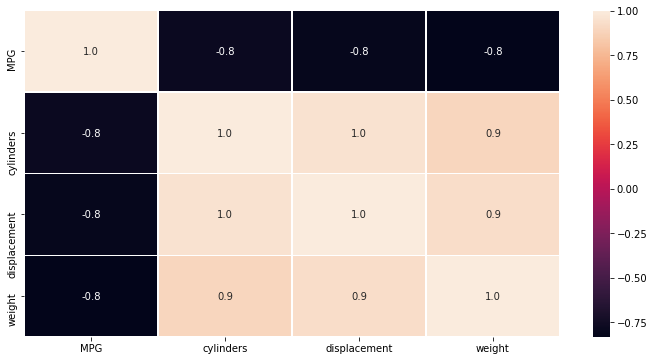

In [71]:
# Bagımlı değişkenimizle sadece yüksek kolerasyonu (ilişkisi) olan kolonlara bakalım.   
treshold = .75 # kolerasyonu 0.75den yüksek olanları grafiğini çizdirelim
filtre = np.abs(corr_matrix['MPG'])>treshold # np.abs mutlak değerini alarak çalışır
corr_feature = corr_matrix.columns[filtre].tolist() # Belirlediğimiz treshold(eşik değer)'i geçen özellikleri listeye çevirdik
corr=auto[corr_feature].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, linecolor="w", linewidths=.5, fmt=".1f")
plt.show()

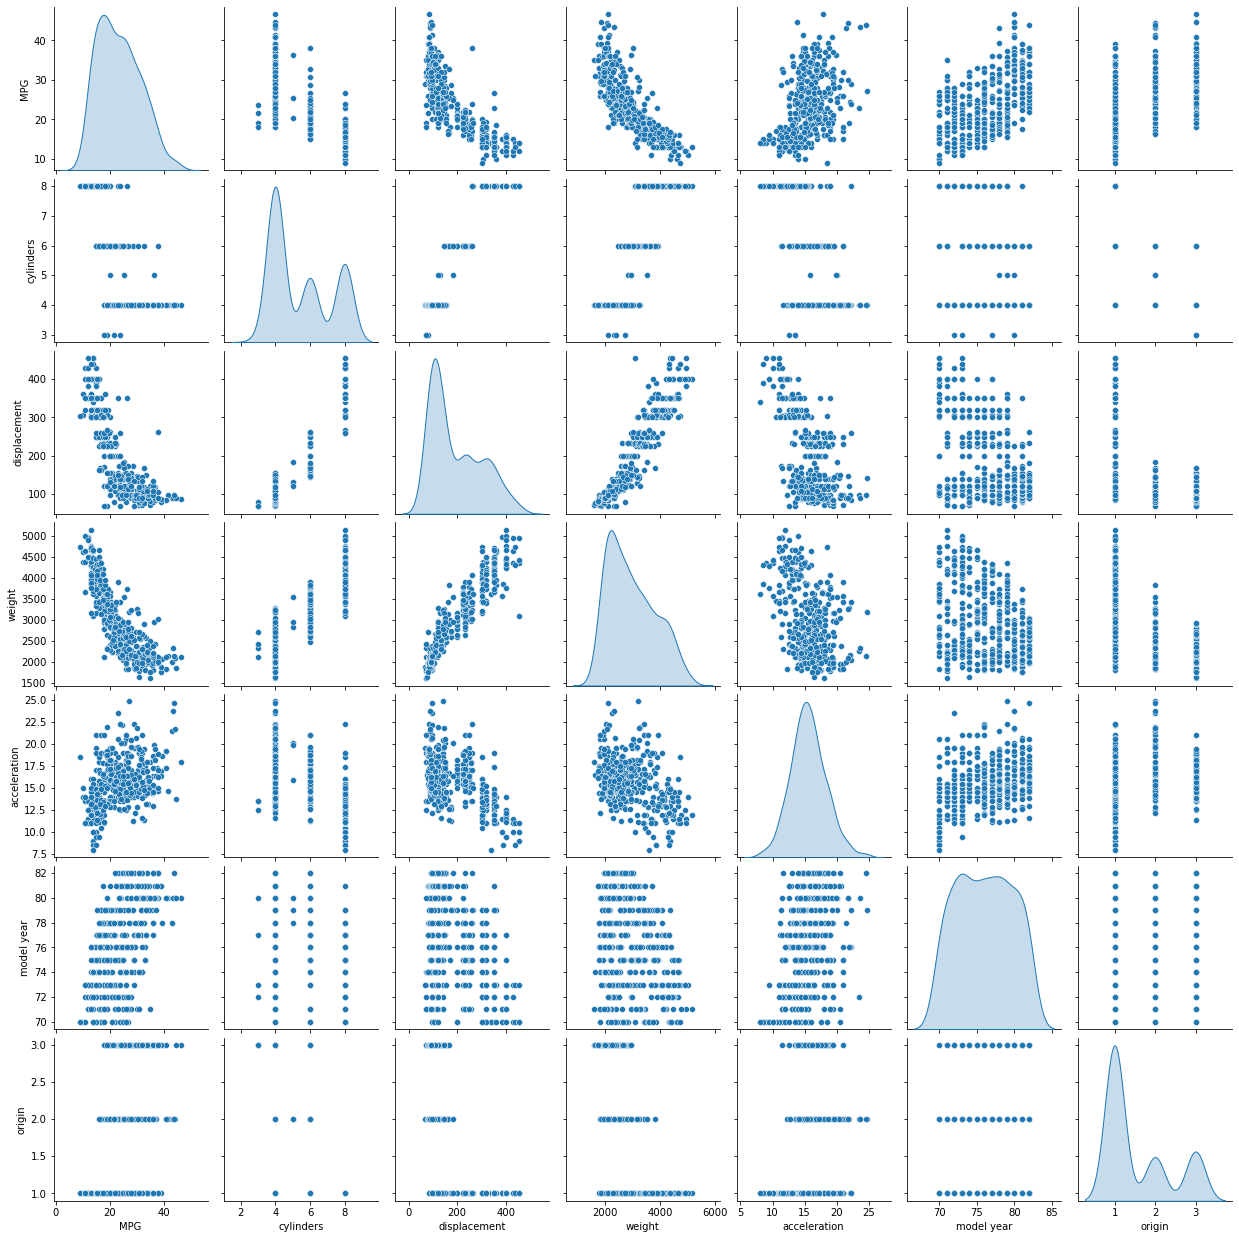

In [12]:
# Colonların dağılımlarınının grafiğini çizdirelim
sns.pairplot(auto, diag_kind = "kde")
plt.show()

In [72]:
# Araç isimlerini drop edelim.
auto.drop("car name", axis=1, inplace=True)

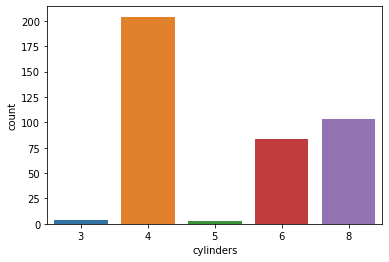

In [14]:
sns.countplot(auto.cylinders)
plt.show()

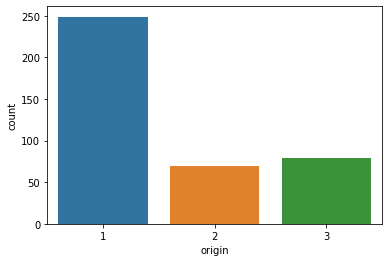

In [73]:
sns.countplot(auto.origin)
plt.show()

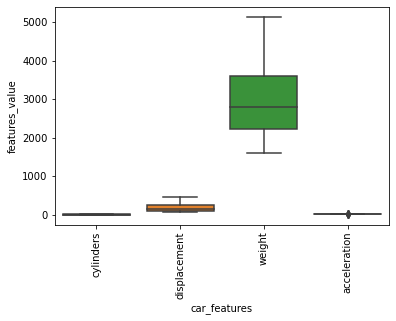

In [74]:
# Belirlediğimiz kolonların kutu grafiğini çizdirelim
value_vars =['MPG', 'cylinders', 'displacement', 'weight', 'acceleration']
df_melted = pd.melt(auto[value_vars],id_vars='MPG',  var_name='car_features', value_name='features_value')
plt.figure()
sns.boxplot(x ='car_features', y='features_value', data=df_melted)
plt.xticks(rotation=90)
plt.show()

In [75]:
# Horsepower kolonunu sayısal değere çevirmeden önce verideki soru işaretnini boş değer olarak değiştirmemiz gerekir
auto["horsepower"].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [81]:
auto["horsepower"]=auto["horsepower"].replace('?',np.nan)

In [83]:
#Şimdi sayısal değere çevirebiliriz. 
auto["horsepower"] = auto['horsepower'].astype('float')

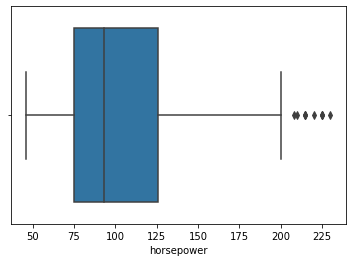

In [84]:
# Horsepower kolonunda aykırı gözlemler bulunmakta
sns.boxplot(x = "horsepower", data = auto)

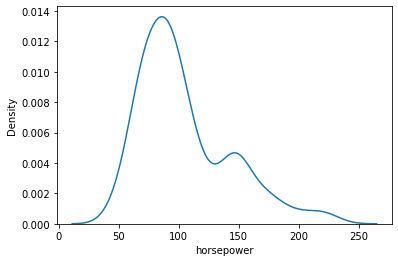

In [32]:
sns.kdeplot(x = "horsepower", data = auto)

In [85]:
# Soru işaretlerini kaldırınca horsepower kolonunda 6 tane eksik gözlem olduğunu fark ettik.
auto.isnull().sum()

MPG             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [86]:
# Horsepower kolonundaki eksik gözlemleri inceleyelim
auto[auto["horsepower"].isnull()]

,MPG,cylinders,displacement,horsepower,weight,acceleration,model year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,1
126,21.0,6,200.0,NaN,2875,17.0,74,1
330,40.9,4,85.0,NaN,1835,17.3,80,2
336,23.6,4,140.0,NaN,2905,14.3,80,1
354,34.5,4,100.0,NaN,2320,15.8,81,2
374,23.0,4,151.0,NaN,3035,20.5,82,1


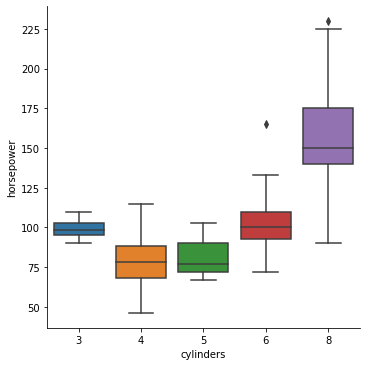

In [35]:
sns.factorplot(x = "cylinders", y = "horsepower", data = auto, kind = "box")
plt.show()

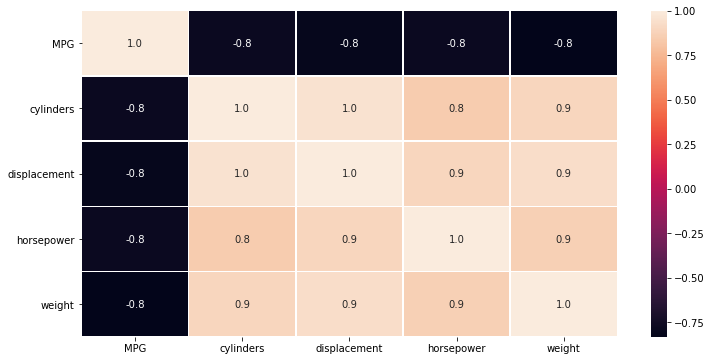

In [89]:
# Horsepower ile kolerasyonu yüksek olanları belirleyelim
corr_matrix = auto.corr()
treshold = .75
filtre = np.abs(corr_matrix["horsepower"])>treshold
corr_feature = corr_matrix.columns[filtre].tolist()
corr=auto[corr_feature].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, linecolor="w", linewidths=.5, fmt=".1f")
plt.show()

In [90]:
# Eksik gözlemleri dolduralım
auto_horsepower_nan_index = list(auto[auto["horsepower"].isnull()].index) # Horsepower kolonundaki eksik gözlemlerin indexlerini listeye atalım
for index in auto_horsepower_nan_index:  # for döngüsü ile her her bir index için verdiğimiz koşula göre dolduralım 
    cylinders = auto["cylinders"]==auto.iloc[index]["cylinders"]
    acceleration = auto["acceleration"]==auto.iloc[index]["acceleration"]
    horsepower_predictions = auto["horsepower"][(cylinders) & (acceleration)].median()
    if not np.isnan(horsepower_predictions):
        auto["horsepower"].iloc[index] = horsepower_predictions

In [91]:
# Gördüğünüz gibi verdiğimiz koşula uymayan bir gözlem çıktı
auto[auto["horsepower"].isnull()]

,MPG,cylinders,displacement,horsepower,weight,acceleration,model year,origin
336,23.6,4,140.0,NaN,2905,14.3,80,1


In [93]:
# bu gözlemi ise horsepower kolonunun genel ortalamasını atayalım
auto["horsepower"].fillna(auto["horsepower"].mean(), inplace=True)

In [94]:
# Hiç eksik gözlemimiz kalmadı
auto.isnull().sum()

MPG             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [95]:
# Aykırı değerleri localoutlierfactor algoritması ile belirleyelim
y = auto["MPG"]
x = auto.drop(["MPG"], axis=1)
#columns = x.columns.tolist()
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)

In [96]:
# Tüm gözlemleri aykırılıklarına göre puanlama yaptı.
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score
outlier_score.head()

,score
0,-1.059715
1,-1.002477
2,-1.021389
3,-0.986958
4,-0.986100


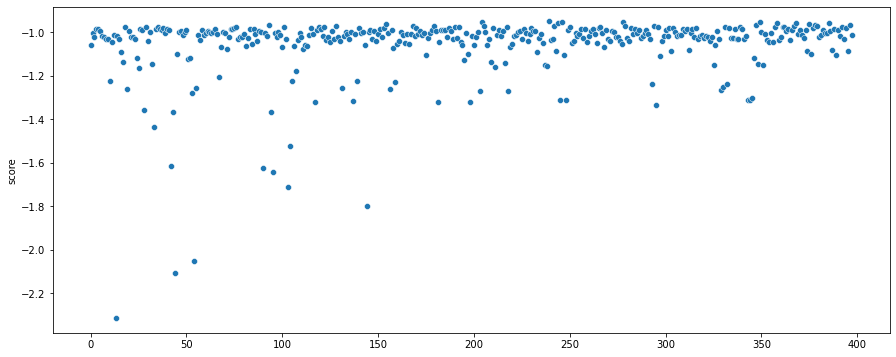

In [97]:
# Eldde ettiğimiz aykırılık skorununun grafiğini çizdirelim.
plt.figure(figsize=(15,6))
sns.scatterplot(x=outlier_score.index.values,y=outlier_score["score"])
plt.show()

In [98]:
# Bİr eşik değer belirleyelim ve bu eşik değeri aşan gözlemleri silelim.
outlier_index = outlier_score[outlier_score["score"]<-2].index.tolist()
outlier_index

[13, 44, 54]

In [99]:
auto = auto.drop(outlier_index)

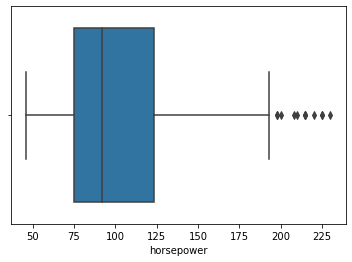

In [100]:
columns = ["acceleration", "horsepower"]
for feature in columns:
    plt.figure()
    sns.boxplot(x=feature, data=auto)

In [101]:
# Diğer aykırı gözlemleri kendi kolonlarındaki alt ve üst sınırlara eşitleyelim.
columns = ["acceleration", "horsepower"]
for column in columns:

    outliers_lower_indexs = []
    outliers_high_indexs = []

    quantile_one = auto[column].quantile(0.25)
    quantile_three = auto[column].quantile(0.75)
    iqr = quantile_three-quantile_one
    Lower_tail = quantile_one - 1.5 * iqr
    Upper_tail = quantile_three + 1.5 * iqr

    for index, value in enumerate(auto[column]):
        if value > Upper_tail:
            outliers_high_indexs.append(index)
        elif  value < Lower_tail:
            outliers_lower_indexs.append(index)
            
    auto.loc[outliers_lower_indexs, column] = Lower_tail
    auto.loc[outliers_high_indexs, column] = Upper_tail

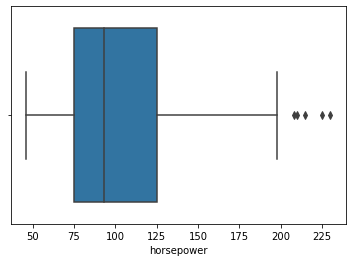

In [102]:
for feature in columns:
    plt.figure()
    sns.boxplot(x=feature, data=auto)

In [103]:
#Bağımlı değişkenimizin ortalama ve standart sapmasını inceleyelim
(mean, standard_deviation) = norm.fit(auto["MPG"])
print((mean, standard_deviation))

(23.536202531645568, 7.781736538454488)


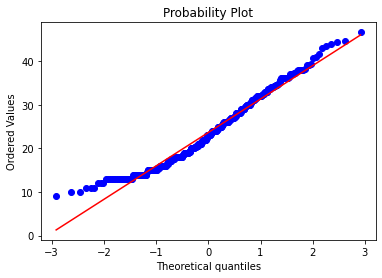

In [57]:
# Bağımlı değişkenimizin normal dağılıma uygunluğuna bakalım
plt.figure()
stats.probplot(auto["MPG"],plot=plt)
plt.show()

In [104]:
# Modelimize uygun hale gelmesi için kolonlarımızı hazırlayalım
auto = pd.get_dummies(auto, columns=["origin"])
auto = pd.get_dummies(auto, columns=["cylinders"])

In [59]:
auto.head()

,MPG,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,18.0,307.0,130.0,3504,12.0,70,1,0,0,0,0,0,0,1
1,15.0,350.0,165.0,3693,11.5,70,1,0,0,0,0,0,0,1
2,18.0,318.0,150.0,3436,11.0,70,1,0,0,0,0,0,0,1
3,16.0,304.0,150.0,3433,12.0,70,1,0,0,0,0,0,0,1
4,17.0,302.0,140.0,3449,10.5,70,1,0,0,0,0,0,0,1


In [105]:
x = auto.drop(["MPG"],axis=1) # Bağımsız değişkenler
y = auto.MPG # bağımlı(hedef) değişken
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42) # eğitim ve test olarak ayıralım
scaler = StandardScaler() # Gözlemlerin Boyutunu ölçeklendirelim
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [106]:
'''
AUTOML modellerinden iri olan Tpot'u şimdi kullanabiliriz verimiz artık hazır.
Gerekli kütüphaneleri indirelim
'''
!pip install deap update_checker tqdm stopit xgboost
!pip install scikit-mdr skrebate
!pip install tpot

In [107]:
'''
VErimiz regresyon problemi olduğu için  TPOTRegressor kullanacağız Ama sınıflandırma problemi olsaydı TPOTClassifier kullanırdık.
'''
from tpot import TPOTClassifier
from tpot import TPOTRegressor
tpot = TPOTRegressor(verbosity=2, max_time_mins=5, population_size=40, n_jobs=-1, random_state=42)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))


Generation 1 - Current best internal CV score: -7.357359628279819

Generation 2 - Current best internal CV score: -7.0490326252955935

Generation 3 - Current best internal CV score: -7.0490326252955935

Generation 4 - Current best internal CV score: -6.741116181594551

Generation 5 - Current best internal CV score: -6.741116181594551

Generation 6 - Current best internal CV score: -6.741116181594551

Generation 7 - Current best internal CV score: -6.696028068040171

Generation 8 - Current best internal CV score: -6.696028068040171

Generation 9 - Current best internal CV score: -6.696028068040171

5.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(ZeroCount(LassoLarsCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), normalize=False)), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=4

In [108]:
'''
Şimdi modelimizin skorlarına bakalım.
'''
y_predicted = tpot.predict(x_test)
print("tpot score :", tpot.score(x_test, y_test))
print("tpot explained_variance_score :",explained_variance_score(y_test, y_predicted))
print("tpot mean_absolute_error :", mean_absolute_error(y_test, y_predicted))
print("tpot max_error :", max_error(y_test, y_predicted))
print("tpot r2_score :", r2_score(y_test, y_predicted))
print("tpot mean_squared_error :", mean_squared_error(y_test, y_predicted))

tpot score : -9.093276451251853
tpot explained_variance_score : 0.8299867532053226
tpot mean_absolute_error : 1.9085230381010692
tpot max_error : 16.29447019647022
tpot r2_score : 0.8299867387959918
tpot mean_squared_error : 9.093276451251853


In [0]:
'''
Bir başka aykırı gözlem algoritması isterseniz bunu da kullanabilirsiniz.

from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(x_train_df)

# predictions
y_pred_train = clf.predict(x_train_df)
#y_pred_test = clf.predict(x_test)


from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
radius = mm_scaler.fit_transform(outlier_score)
outlier_score["radius"] = radius
plt.figure(figsize=(6,6))
sns.scatterplot(y=outlier_score["radius"],x=outlier_score["score"], color="r")
plt.show()

'''